In [1]:
# from gensim.models import word2vec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# 1. 資料前處理
目標是把四年度的球員隊伍名單整理成一個文字檔案，每一行代表 某年度某一隊的陣容名單

In [2]:
# 用來存整理好的陣容名單 [{'哪一年哪一隊': 球員名單list}, ...]
team_member = []

## 讀取 NBA 球員資料

In [3]:
data_dir = "nba_data/"

- NBA 2017 ~ 2018

In [4]:
df = pd.read_csv(data_dir+"17-18.csv", header=0)
# 依據隊伍，把每個球員讀出成一個 list，存起來
for team in df['TEAM'].unique():
    team_member.append({'team': '17_'+team, 'members': ','.join(df[df['TEAM'] == team]['FULL NAME'].values)})

- NBA 2018 ~ 2019

In [5]:
df = pd.read_csv(data_dir+"18-19.csv", header=0)
# 依據隊伍，把每個球員讀出成一個 list，存起來
for team in df['TEAM'].unique():
    team_member.append({'team': '18_'+team, 'members': ','.join(df[df['TEAM'] == team]['FULL NAME'].values)})

- NBA 2019 ~ 2020

In [6]:
df = pd.read_csv(data_dir+"19-20.csv", header=0)
# 依據隊伍，把每個球員讀出成一個 list，存起來
for team in df['TEAM'].unique():
    team_member.append({'team': '19_'+team, 'members': ','.join(df[df['TEAM'] == team]['FULL NAME'].values)})

- NBA 2020 ~ 2021

In [7]:
df = pd.read_csv(data_dir+"20-21.csv", header=0)
# 依據隊伍，把每個球員讀出成一個 list，存起來
for team in df['TEAM'].unique():
    team_member.append({'team': '20_'+team, 'members': ','.join(df[df['TEAM'] == team]['FULL NAME'].values)})

### 將四份檔案整合成一個 DataFrame 並存檔

In [8]:
# List 轉為 DataFrame
team_member_df = pd.DataFrame(team_member, columns=['team', 'members'])

- 建立一個 DataFrame 來存每一年每一個球隊的球員名單(球員以逗號分隔)

In [9]:
team_member_df.to_csv(data_dir+'processed/nba_team_member_17-20.csv', index = False)
corpus = team_member_df['members']
team_member_df.head()

,team,members
0,17_Min,"Aaron Brooks,Andrew Wiggins,Anthony Brown,Cole..."
1,17_Orl,"Aaron Gordon,Adreian Payne,Arron Afflalo,Bisma..."
2,17_Dal,"Aaron Harrison,Antonius Cleveland,Dennis Smith..."
3,17_Hou,"Aaron Jackson,Bobby Brown,Brandan Wright,Brian..."
4,17_Bos,"Abdel Nader,Al Horford,Aron Baynes,Daniel Thei..."


- 找出所有球隊這四年中，有最多球員的數量，用於設置 window_size，也順帶找出最少球員的數量

In [10]:
max_len = 0
max_index = 0
min_len = 100
min_index = 0
for i, members in enumerate(corpus):
    if len(members.split(',')) > max_len:
        max_len = len(members.split(','))
        max_index = i
    if len(members.split(',')) < min_len:
        min_len = len(members.split(','))
        min_index = i
        
print('Sequence 最長長度:', max_len)
print('編號:', max_index)
print('Sequence 最短長度:', min_len)
print('編號:', min_index)

Sequence 最長長度: 28
編號: 42
Sequence 最短長度: 13
編號: 117


- 建立詞典，保存從球員名字到index的映射

In [11]:
vocab, index = {}, 1 # start indexing from 1
vocab['<pad>'] = 0 # add a padding token
for members in corpus:
    for token in members.split(','):
        if token not in vocab: 
            vocab[token] = index
            index += 1

vocab_size = len(vocab)
print('詞典長度:', len(vocab))

詞典長度: 856


- 創建逆詞典，保存從index到球員名字的映射

In [12]:
inverse_vocab = {index: token for token, index in vocab.items()}

- 將所有球員名單句子向量化

In [13]:
window_size = max_len
ns_num = 5

x = []
y = []
for sequence in corpus:
    tmp = [vocab[word] for word in sequence.split(',')]
    skip_grams, labels = tf.keras.preprocessing.sequence.skipgrams(
        tmp,
        vocabulary_size=vocab_size,
        window_size=window_size,
        negative_samples=ns_num,
        shuffle=True)
    x.extend(skip_grams)
    y.extend(labels)
    
x = np.array(x)
target = x[:,0]
context = x[:,1]
y = np.array(y)
y = np.expand_dims(y, axis=1)


# 2. Word2vec 模型

In [14]:
dim_embedddings = 32

# Inputs
w_inputs = Input(shape=(1, ), dtype='int32')
c_inputs = Input(shape=(1, ), dtype='int32')

# Share Embedding Matrix
embedding_matrix = Embedding(vocab_size, dim_embedddings)

# target embedding
w = embedding_matrix(w_inputs)
# context embedding
c  = embedding_matrix(c_inputs)

# Dot Product of the two embeddings
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)
# o = Activation('sigmoid')(o)

nba2vec = Model(inputs=[w_inputs, c_inputs], outputs=o)
nba2vec.summary()
nba2vec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        27392       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding[0][0]       

### 模型訓練

In [15]:
h = nba2vec.fit(x=[target, context], y=y, epochs=50, callbacks=[tensorboard_callback], batch_size=1024)

Epoch 1/50
  1/248 [..............................] - ETA: 0s - loss: 1.4998 - accuracy: 0.8535

W0115 14:55:56.845080 139661804726080 deprecation.py:323] From /home/q56084098/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
W0115 14:55:56.858765 139661804726080 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_train_batch_end` time: 0.0147s). Check your callbacks.


248/248 [==============================] - 1s 4ms/step - loss: 1.5598 - accuracy: 0.8333
Epoch 2/50
248/248 [==============================] - 1s 4ms/step - loss: 1.0619 - accuracy: 0.8333
Epoch 3/50
248/248 [==============================] - 1s 3ms/step - loss: 0.8021 - accuracy: 0.8333
Epoch 4/50
248/248 [==============================] - 1s 4ms/step - loss: 0.6551 - accuracy: 0.8333
Epoch 5/50
248/248 [==============================] - 1s 4ms/step - loss: 0.5720 - accuracy: 0.8333
Epoch 6/50
248/248 [==============================] - 1s 4ms/step - loss: 0.5135 - accuracy: 0.8334
Epoch 7/50
248/248 [==============================] - 1s 4ms/step - loss: 0.4672 - accuracy: 0.8335
Epoch 8/50
248/248 [==============================] - 1s 4ms/step - loss: 0.4305 - accuracy: 0.8340
Epoch 9/50
248/248 [==============================] - 1s 4ms/step - loss: 0.4014 - accuracy: 0.8347
Epoch 10/50
248/248 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.8362
Epoch 11/5

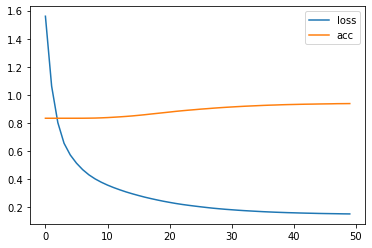

In [16]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['accuracy'], label='acc')
plt.legend(loc='upper right')
plt.show()

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir logs

### 構建一個從 球員姓名 至 Embedding 的映射

In [18]:
vocab_to_emb = {}
vectors = nba2vec.get_weights()[0]
for word, i in vocab.items():
    vocab_to_emb[word] = vectors[i, :]

# 3. 實驗 Embedding 的品質

- 建構一個從 球員姓名 至 球員Embedding 的映射

In [19]:
vocab_to_emb = {}
vectors = nba2vec.get_weights()[0]
for word, i in vocab.items():
    vocab_to_emb[word] = vectors[i, :]

保存訓練好的 Embedding，分為:
1. metadata.tsv : 每一列為球員姓名
2. vectors.tsv : 每一列為一個球員的 Embedding

### 這兩個檔案後續可以上傳至 Embedding Projector 網站，進行線上手動分析
 https://projector.tensorflow.org/ 

In [20]:
out_v = io.open('player_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('player_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = vectors[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
    
out_v.close()
out_m.close()

### 隨意選出幾個球星，計算其相似度，是否有體現出隊友相似度高、非隊友相似度低

In [21]:
from scipy.spatial.distance import cosine

def cos_sim(a, b):
    return 1 - cosine(a, b)

def print_sim(playerA='', playerB=''):
    print('Cosine similarity of {} to {} is: {}'.format(playerA, 
                                                        playerB, 
                                                        cos_sim(vocab_to_emb[playerA], vocab_to_emb[playerB])))

In [25]:
print_sim('LeBron James', 'Stephen Curry')
print_sim('LeBron James', 'Derrick Rose')
print_sim('LeBron James', 'Anthony Davis')
print_sim('LeBron James', 'Kyle Kuzma')
print_sim('LeBron James', 'Kawhi Leonard')
print_sim('LeBron James', 'Kevin Durant')
print_sim('Stephen Curry', 'Kevin Durant')
print_sim('Stephen Curry', 'Klay Thompson')

Cosine similarity of LeBron James to Stephen Curry is: -0.06379831582307816
Cosine similarity of LeBron James to Derrick Rose is: 0.2705168128013611
Cosine similarity of LeBron James to Anthony Davis is: 0.42189159989356995
Cosine similarity of LeBron James to Kyle Kuzma is: 0.7576419115066528
Cosine similarity of LeBron James to Kawhi Leonard is: -0.03167477995157242
Cosine similarity of LeBron James to Kevin Durant is: 0.16373300552368164
Cosine similarity of Stephen Curry to Kevin Durant is: 0.5692143440246582
Cosine similarity of Stephen Curry to Klay Thompson is: 0.8193364143371582


### 計算出 30 個球隊的 Embedding，觀察哪些球隊比較相近

整理資料，將四年內，每一支球隊曾經有擁有過的球員放在一起

先找出總共有哪些球隊

In [58]:
team_dict = {}
for team in team_member_df['team'].unique():
    team = team[3:]
    if team not in team_dict:
        team_dict[team] = []

print(team_dict.keys())

dict_keys(['Min', 'Orl', 'Dal', 'Hou', 'Bos', 'Ind', 'Pho', 'Uta', 'Okc', 'Lal', 'Por', 'Tor', 'Bro', 'Phi', 'Det', 'Gol', 'Mem', 'Atl', 'Cle', 'Nor', 'Chi', 'Lac', 'Mia', 'Sac', 'Was', 'Mil', 'San', 'Cha', 'Nyk', 'Den'])


把四年內所有出現過的球員都存進該球隊的 dict 中，並刪除重複項目

In [60]:
for index, row in team_member_df.iterrows():
    members = row['members'].split(',')
    team_dict[row['team'][3:]].extend(members)
    
for key, item in team_dict.items():
    item = list(dict.fromkeys(item))
    team_dict[key] = item

隨意顯示一隻球隊，此處以湖人隊為例，四年內總共有 57 位球員待過

In [61]:
print(len(team_dict['Lal']))
print(team_dict['Lal'])

57
['Alex Caruso', 'Andre Ingram', 'Andrew Bogut', 'Brandon Ingram', 'Brook Lopez', 'Channing Frye', 'Corey Brewer', 'Derrick Williams', 'Gary Payton II', 'Isaiah Thomas', 'Ivica Zubac', 'Jordan Clarkson', 'Josh Hart', 'Julius Randle', 'Kentavious Caldwell-Pope', 'Kyle Kuzma', 'Larry Nance Jr.', 'Lonzo Ball', 'Luol Deng', 'Nigel Hayes', 'Thomas Bryant', 'Travis Wear', 'Tyler Ennis', 'Vander Blue', 'Michael Beasley', 'Isaac Bonga', 'Reggie Bullock', 'Tyson Chandler', 'LeBron James', 'Jemerrio Jones', 'Scott Machado', 'JaVale McGee', 'Mike Muscala', 'Svi Mykhailiuk', 'Rajon Rondo', 'Lance Stephenson', 'Moritz Wagner', 'Johnathan Williams', 'Kostas Antetokounmpo', 'Avery Bradley', 'Devontae Cacok', 'Quinn Cook', 'Troy Daniels', 'Anthony Davis', 'Jared Dudley', 'Danny Green', 'Talen Horton-Tucker', 'Dwight Howard', 'Markieff Morris', 'Zach Norvell Jr.', 'JR Smith', 'Dion Waiters', 'Marc Gasol', 'Montrezl Harrell', 'Dennis Schroder', 'Wesley Matthews', 'Alfonzo McKinnie']


### 將每支球隊中所有球員 Embedding 平均，得到球隊 Embedding

In [83]:
def avg_sentence_vector(sequence, vocab_to_emb, dim_embedddings):
    featureVec = np.zeros((dim_embedddings,), dtype="float32")
    nwords = 0
    for player in sequence:
        if player in vocab_to_emb.keys():
            featureVec = np.add(featureVec, vocab_to_emb[player])

    return featureVec / len(sequence)


every_team_emb = {}
for key, item in team_dict.items():
    emb = avg_sentence_vector(team_dict[key], vocab_to_emb, dim_embedddings)
    every_team_emb[key] = emb

In [86]:
out_v = io.open('team_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('team_metadata.tsv', 'w', encoding='utf-8')


for key, vec in every_team_emb.items():
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(key + "\n")
    
out_v.close()
out_m.close()